In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Launch deployment

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=20, 
    memory='10 GB',
    walltime="00:20:00",
    log_directory='job_logs'
)

In [13]:
client.close()
cluster.close()

In [3]:
client = Client(cluster)
cluster.scale(100)
#cluster.adapt(maximum=100)

In [7]:
client

Client Scheduler: tcp://10.110.16.11:45825 Dashboard: http://10.110.16.11:8787/status,Cluster Workers: 4 Cores: 16 Memory: 8.00 GB


# Read and normalize data
The spectra are normalized by the sum siginal in each row. For now, I don't think clr is needed yet.

In [2]:
merge_df = pd.read_csv('data/spe+bulk_dataset_20201008.csv', index_col = 0)
merge_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,TC%,TOC%,CaCO3%,core,mid_depth_mm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.542079,0.394127,17.898887,SO264-64-1,115
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.247150,0.611208,13.632300,SO264-64-1,215
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.710588,0.523402,1.559822,SO264-64-1,305
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.562171,0.472551,0.746802,SO264-64-1,1015
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.578167,0.312852,2.210866,SO264-64-1,1815


In [3]:
X = merge_df.iloc[:, :-5].values
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X = X / X.sum(axis = 1, keepdims = True)
X.shape

(382, 2048)

# Run PCA
To guess the possible components.

In [5]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = make_pipeline(StandardScaler(), PCA(n_components = 0.9))
pca.fit(X)

CPU times: user 1.6 s, sys: 37.8 ms, total: 1.64 s
Wall time: 390 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9))])

In [6]:
len(pca.named_steps['pca'].explained_variance_ratio_)

194

<BarContainer object of 194 artists>

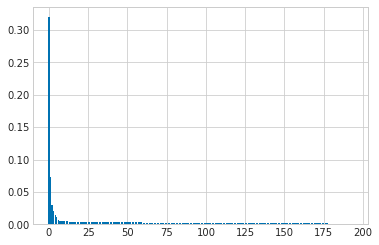

In [16]:
plt.bar(range(len(pca.named_steps['pca'].explained_variance_ratio_)), pca.named_steps['pca'].explained_variance_ratio_)

<BarContainer object of 30 artists>

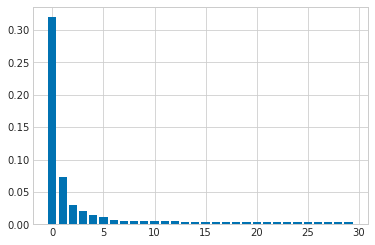

In [17]:
plt.bar(range(30), pca.named_steps['pca'].explained_variance_ratio_[:30])

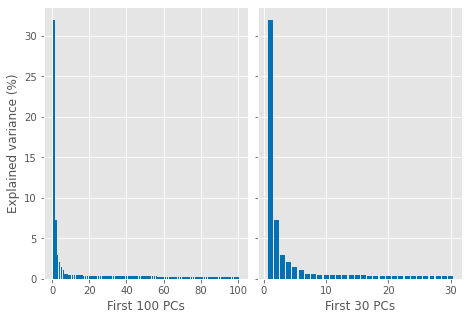

In [15]:
fug, ax = plt.subplots(1, 2, sharey = 'row', figsize = (7.5, 5))
ax[0].bar(range(1, 101), pca.named_steps['pca'].explained_variance_ratio_[:100]*100)
ax[1].bar(range(1, 31), pca.named_steps['pca'].explained_variance_ratio_[:30]*100)
ax[0].set_xlabel('First 100 PCs')
ax[1].set_xlabel('First 30 PCs')
ax[0].set_ylabel('Explained variance (%)')
plt.subplots_adjust(wspace = .05)
plt.savefig('results/pca_screeplot_{}.png'.format(date))

Potential component number would be 6.

# Build model for CaCO3

In [8]:
from dask_ml.model_selection import train_test_split
merge_df = dd.read_csv('data/spe+bulk_dataset_20201008.csv')
X = merge_df.iloc[:, 1: -5].to_dask_array(lengths=True)
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['CaCO3%'].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

In [8]:
X_train

dask.array<from-value, shape=(305, 2048), dtype=float64, chunksize=(305, 2048), chunktype=numpy.ndarray>

In [7]:
X_test

dask.array<from-value, shape=(77, 2048), dtype=float64, chunksize=(77, 2048), chunktype=numpy.ndarray>

## A glance at the split

In [9]:
y_ttest = np.array(y_test)
y_ttrain = np.array(y_train)

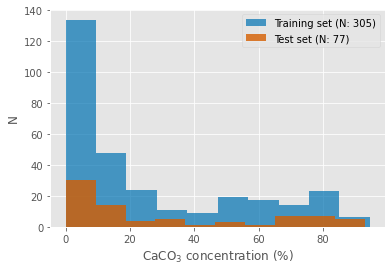

In [11]:
plt.hist(y_ttrain, alpha=.7, label='Training set (N: {})'.format(len(y_ttrain)))
plt.hist(y_ttest, color='C2', alpha=.8, label='Test set (N: {})'.format(len(y_ttest)))
plt.xlabel('CaCO${_3}$ concentration (%)')
plt.ylabel('N')
plt.legend()
plt.savefig('results/caco3_histogram_{}.png'.format(date))

## Grid search 1
We know the relationship between the spectra and bulk measurements might not be linear; and based on the pilot_test.ipynb, the SVR algorithm with NMF transformation provides the better cv score. So we focus on grid search with NMF transformation (4, 5, 6 and 7 components based on the PCA result) and SVR. 

In [9]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(max_iter = 2000, random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 10, n_jobs = -1)  

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_)) 
print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print('The best model\'s parameters: {}'.format(grid.best_estimator_))

The best cv score: 0.976
The test score: 0.959
The best model's parameters: Pipeline(steps=[('nmf', NMF(max_iter=2000, n_components=6, random_state=24)),
                ('svr', SVR(C=1000000.0, gamma=1.0))])
CPU times: user 11.3 s, sys: 456 ms, total: 11.7 s
Wall time: 22.7 s


In [14]:
y_predict = grid.best_estimator_.predict(X_test)
y_ttest = np.array(y_test)

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
print('Scores in the test set:')
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_ttest, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_ttest, y_predict)))

Scores in the test set:
The mean absolute error is 3.583 (%, concetration).
The max. residual error is 29.106 (%, concetration).


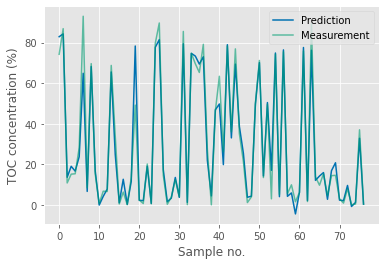

In [16]:
plt.plot(range(len(y_predict)), y_predict, label='Prediction')
plt.plot(range(len(y_predict)), y_ttest, alpha=0.6, label='Measurement')
plt.ylabel('TOC concentration (%)')
plt.xlabel('Sample no.')
plt.legend()
plt.savefig('results/caco3_predictions_gbdt_{}.png'.format(date))

### Visualization

In [17]:
result_df = pd.DataFrame(grid.cv_results_)
result_df.to_csv('results/caco3_gridsearch_nmf+svr_{}.csv'.format(date))
#result_df = pd.read_csv('results/gridsearch_nmf+svr_20201009.csv', index_col = 0)
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

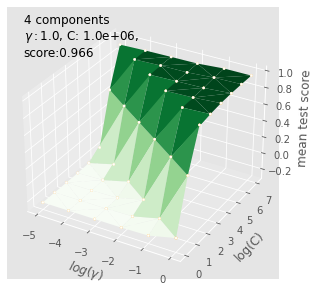

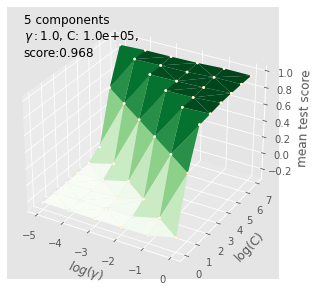

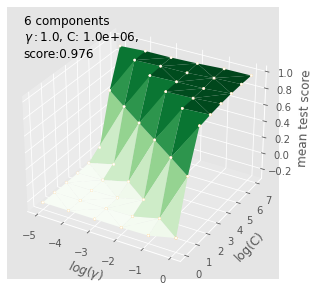

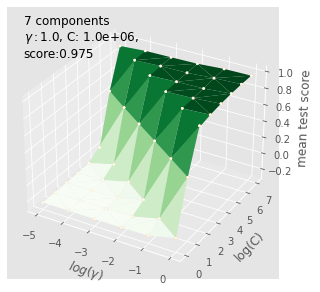

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in [4, 5, 6, 7]:
    data = result_df[result_df.param_nmf__n_components == n_components].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
    # mark the best score
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.1f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(-6, 1, 1.3,text, fontsize=12)

    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('mean test score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/grid_caco3_{}nmr+svr_3D_{}.png'.format(n_components, date))

In [10]:
from joblib import dump, load
#model = load(models/ssss.joblib)
dump(grid.best_estimator_, 'models/caco3_nmf+svr_model_{}.joblib'.format(date)) 

['models/caco3_nmf+svr_model_20201012.joblib']

The dask sesssion fails when I try gamma larger than 1. Although the topography of the scores encourage me to find the down-slope at larger gamma, it is not practical to try that big value of gamma because gamma is an inverted number of the distance for the kernel (radical function) computation. The distance can't be too small otherwise there is no neighboring data points included and raises error in SVR, which makes the worker failed. Also, the test score (0.96, not the cv score) is good enough. Therefore, in this combination, I would choose 6 component NMF and SVR (${\gamma}$: 1, C: 1e+6) as the best model.

## Grid search 2
Due to curiosity, let's try the SVR algorithm with PCA transformation.

In [40]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), PCA(n_components = 6, whiten = True), SVR())
params = {
    'svr__C': np.logspace(0, 6, 7),
    'svr__gamma': np.logspace(-8, 0, 9)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1, error_score = -1)

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_)) 
print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print('The best model\'s parameters: {}'.format(grid.best_estimator_))

The best cv score: 0.974


/home/users/aslee/miniconda3/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


The test score: 0.952
The best model's parameters: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=6, whiten=True)),
                ('svr', SVR(C=10000.0, gamma=0.01))])
CPU times: user 5min 6s, sys: 2min 11s, total: 7min 17s
Wall time: 44.8 s


In [41]:
result_df = pd.DataFrame(grid.cv_results_)
result_df.to_csv('results/caco3_gridsearch_pca+svr_{}.csv'.format(date))
result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

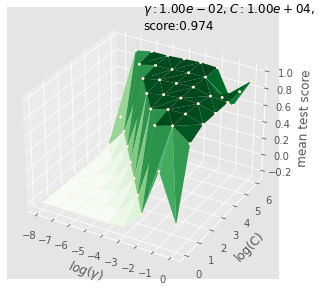

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_svr__gamma.astype(float)
yy = result_df.param_svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.3f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index])-3, np.log10(yy[max_index]), 
        zz[max_index]+.5,text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('results/grid_caco3_pca+svr_3D_{}.png'.format(date))

Both the cv score and test score are alightly lower than the combination of NMF+SVR.

# What? Ridge can have both scores 0.94?
It's so weird... First, linear algorithm shouldnt' be this good. Second, if we don't separate data into training and test sets, the score drops to 0.63. It might be data snooping issue?

## Use split datasets

In [35]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(NMF(random_state = 24), Ridge())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'ridge__alpha': np.logspace(-3, 0, 20)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_)) 
print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print('The best model\'s parameters: {}'.format(grid.best_estimator_))

The best cv score: 0.945
The test score: 0.914
The best model's parameters: Pipeline(steps=[('nmf', NMF(n_components=5, random_state=24)),
                ('ridge', Ridge(alpha=0.001))])
CPU times: user 5.2 s, sys: 163 ms, total: 5.36 s
Wall time: 6.03 s


In [36]:
result_df = pd.DataFrame(grid.cv_results_)

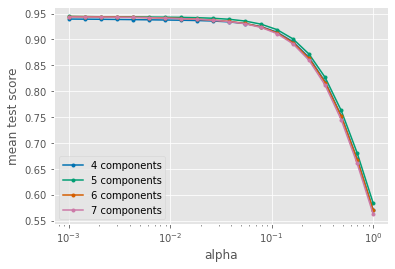

In [41]:
for n in [4, 5, 6, 7]:
    data = result_df[result_df.param_nmf__n_components == n]
    plt.plot(data['param_ridge__alpha'], data['mean_test_score'], marker = 'o', ms = 3, 
             label = '{} components'.format(n))
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')
plt.legend()
fig.savefig('results/grid_caco3_pca+ridge_{}.png'.format(date))

Text(0, 0.5, 'mean test score')

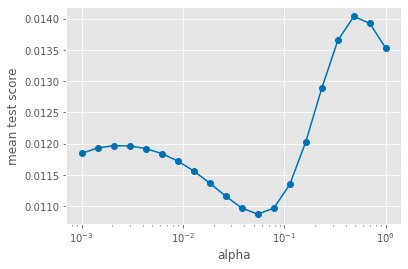

In [42]:
data = result_df[result_df.param_nmf__n_components == 5]
plt.plot(data['param_ridge__alpha'], data['std_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')

## Use the whole dataset

In [7]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(NMF(n_components = 5, random_state = 24), Ridge())
params = {'ridge__alpha': np.logspace(-3, 0, 20)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.646
The best parameter: {'ridge__alpha': 0.008858667904100823}
Pipeline(steps=[('nmf', NMF(n_components=5, random_state=24)),
                ('ridge', Ridge(alpha=0.008858667904100823))])
CPU times: user 698 ms, sys: 32.8 ms, total: 731 ms
Wall time: 5.24 s


Text(0, 0.5, 'mean test score')

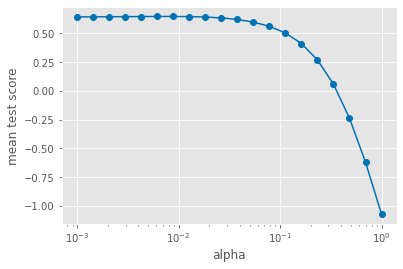

In [8]:
plt.plot(params['ridge__alpha'], grid.cv_results_['mean_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')
#fig.savefig('caco3_pca+ridge_grid_scores.png')